In [17]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Scaricare i dati finanziari (esempio: Apple, intervallo di 1 minuto)
ticker = "AAPL"
df = yf.download(ticker, period="1d", interval="1m")

# Rimuovo il primo livello dell'indice
df = df.droplevel(1, axis=1)  # Rimuove il primo livello delle colonne

# Resample i dati ogni minuto per avere un'unica riga per ogni minuto
df = df.resample("1min").first().ffill()

# Aggiungere una colonna con i tick (numero progressivo di transazioni)
df["tick"] = np.arange(len(df))

df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,tick
Datetime,,,,,,
2025-03-07 14:30:00+00:00,235.059998,235.104996,235.059998,235.104996,492499.0,0
2025-03-07 14:31:00+00:00,235.059998,235.104996,235.059998,235.104996,492499.0,1
2025-03-07 14:32:00+00:00,235.059998,235.104996,235.059998,235.104996,492499.0,2
2025-03-07 14:33:00+00:00,235.232498,235.429993,235.080002,235.195007,998661.0,3
2025-03-07 14:34:00+00:00,236.059998,236.250000,235.220505,235.220505,142344.0,4


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 390 entries, 2025-03-07 14:30:00+00:00 to 2025-03-07 20:59:00+00:00
Freq: min
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   390 non-null    float64
 1   High    390 non-null    float64
 2   Low     390 non-null    float64
 3   Open    390 non-null    float64
 4   Volume  390 non-null    float64
 5   tick    390 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 21.3 KB


In [19]:
# TIME BARS: raggruppare i dati ogni 5 minuti
df_time_bars = df.resample("5min").agg({
    "Open": "first",
    "High": "max",
    "Low": "min",
    "Close": "last",
    "Volume": "sum"
}).dropna()

# VOLUME BARS: creare barre ogni 10.000 azioni scambiate
volume_threshold = 10_000
df["cum_volume"] = df["Volume"].cumsum()
df_volume_bars = df.groupby(df["cum_volume"] // volume_threshold).agg({
    "Open": "first",
    "High": "max",
    "Low": "min",
    "Close": "last",
    "Volume": "sum"
}).dropna()

# TICK BARS: creare barre ogni 10 tick (transazioni)
tick_threshold = 10
df["tick_group"] = df["tick"] // tick_threshold
df_tick_bars = df.reset_index().groupby("tick_group").agg({
    "Datetime": "first",
    "Open": "first",
    "High": "max",
    "Low": "min",
    "Close": "last",
    "Volume": "sum"
}).dropna()

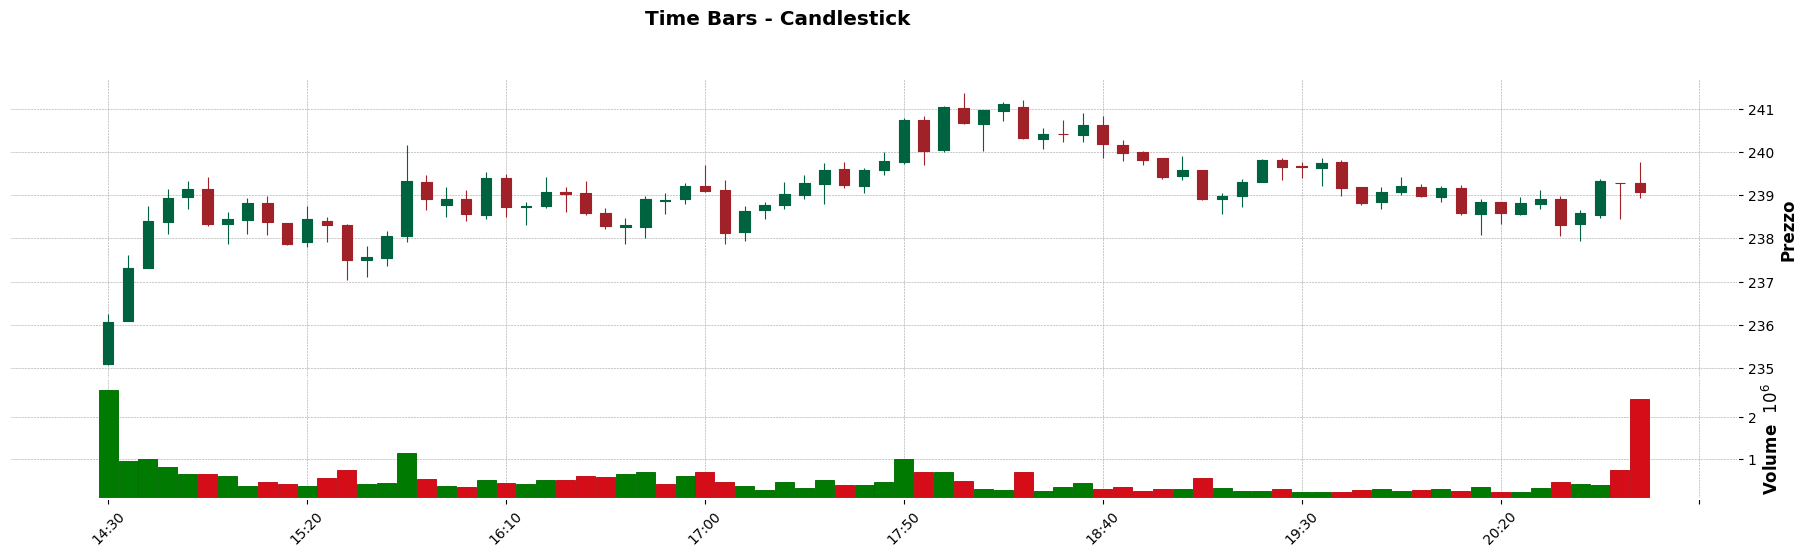

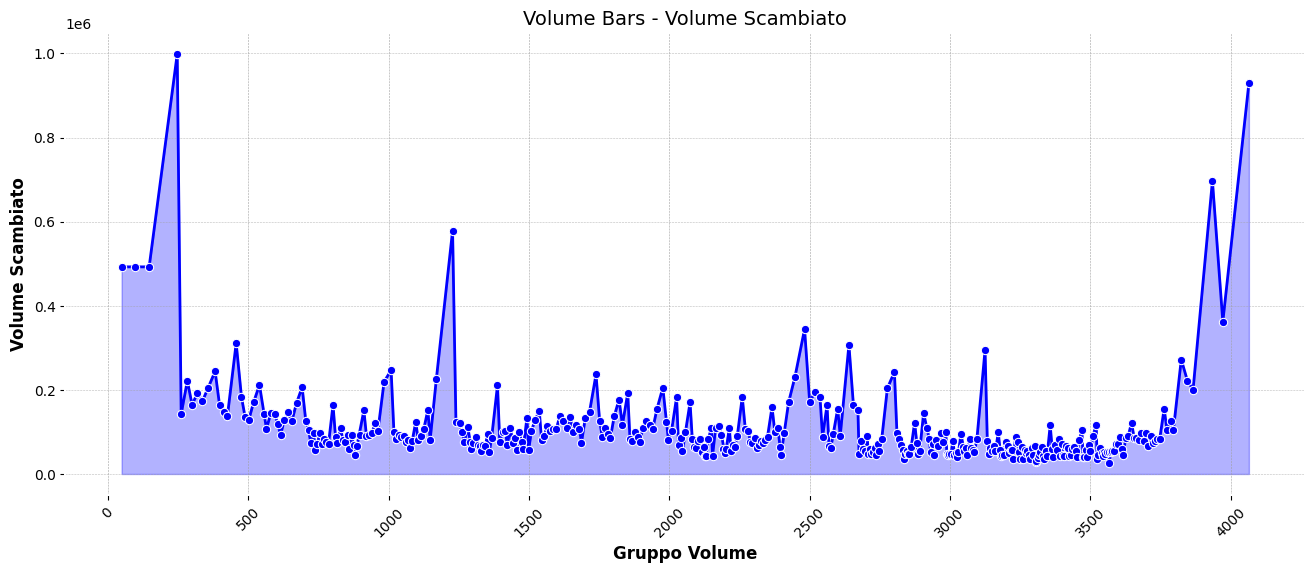

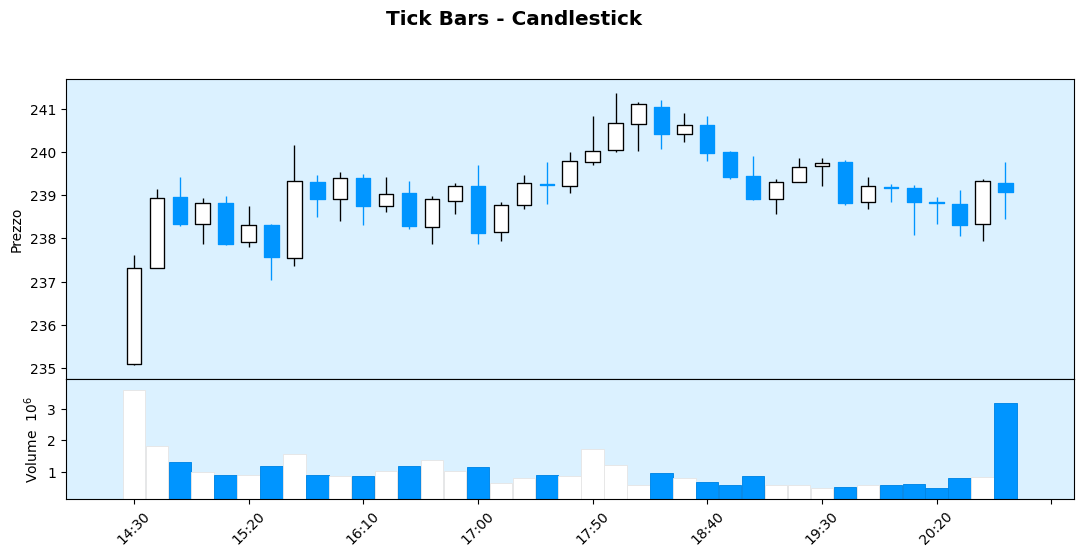

In [20]:
import mplfinance as mpf
import matplotlib.pyplot as plt
import seaborn as sns

def plot_time_bars(df_time_bars):
    """
    Visualizza un grafico a candele per le time bars.
    """
    mpf.plot(
        df_time_bars, type='candle', style='charles', 
        title='Time Bars - Candlestick', ylabel='Prezzo', volume=True,
        figsize=(24, 6)
    )

def plot_volume_bars(df_volume_bars):
    """
    Visualizza un grafico a linee con area sottostante per rappresentare il volume scambiato nelle volume bars.
    """
    fig, ax = plt.subplots(figsize=(16, 6))
    sns.lineplot(x=df_volume_bars.index, y=df_volume_bars["Volume"], marker='o', linewidth=2, color='blue', ax=ax)
    ax.fill_between(df_volume_bars.index, df_volume_bars["Volume"], alpha=0.3, color='blue')
    ax.set_title("Volume Bars - Volume Scambiato", fontsize=14)
    ax.set_xlabel("Gruppo Volume", fontsize=12)
    ax.set_ylabel("Volume Scambiato", fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.show()

def plot_tick_bars(df_tick_bars):
    """
    Visualizza un grafico a candele per le tick bars.
    """
    df = df_tick_bars.copy().set_index('Datetime')  # Imposta Datetime come indice
    df.index = pd.to_datetime(df.index)  # Converti in datetime
    
    mpf.plot(
        df, 
        type='candle', 
        style='blueskies', 
        title='Tick Bars - Candlestick', 
        ylabel='Prezzo', 
        volume=True,
        figsize=(14, 6),
        datetime_format='%H:%M'
    )

# Eseguire le funzioni per generare i grafici
plot_time_bars(df_time_bars)
plot_volume_bars(df_volume_bars)
plot_tick_bars(df_tick_bars)